In [2]:
!pip install -q pandas seaborn

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import seaborn

seaborn.set_theme(style="whitegrid")
matplotlib.rcParams["font.family"] = "CMU Sans Serif"

In [64]:
def fetch_data(task):
    df = pandas.read_csv("build/results.csv", header=None)
    df.loc[:, 4:] = df.loc[:, 4:].div(1e9)
    #df[1] = df[1] / 1e6
    coroutines = df[df[0] == f"c_{task}"]
    threads = df[df[0] == f"tp_{task}"]
    nothreads = df[df[0] == f"single_{task}"]
    return coroutines, threads, nothreads

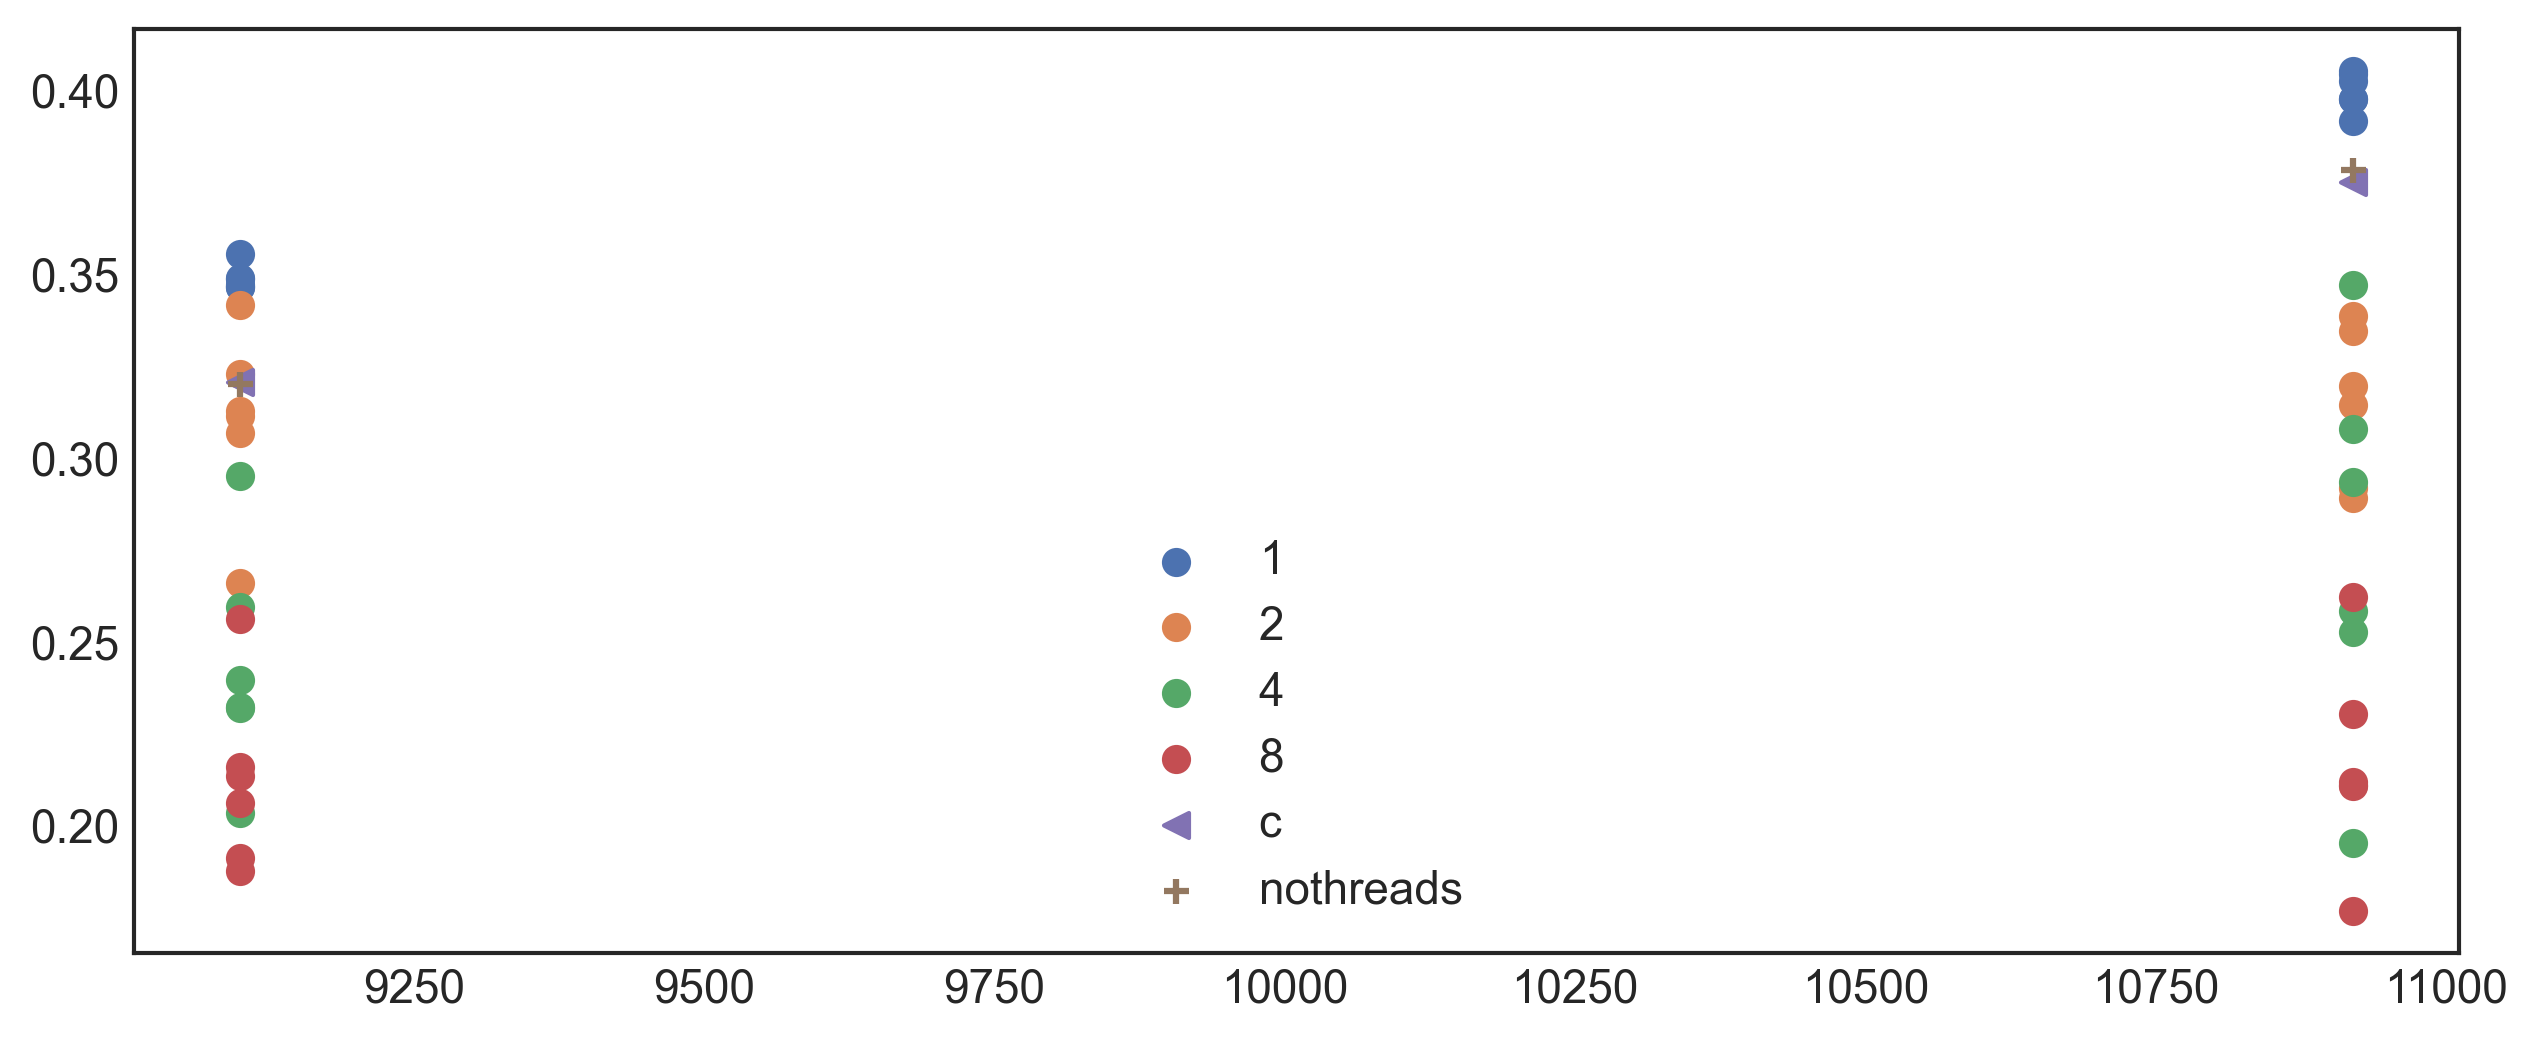

In [63]:
plt.figure(figsize=(10, 4), dpi=300)
for n_threads in [1, 2, 4, 8]:
    n = threads[threads[2] == n_threads]
    plt.scatter(n[1], n[5], label=n_threads)

plt.scatter(coroutines[1], coroutines[5], label="c", marker="<")
plt.scatter(nothreads[1], nothreads[5], label="nothreads", marker="+")

plt.legend()

In [43]:
seaborn.set_style("white")

t_max = threads.groupby(1).max(5)
t_mean =threads.groupby(1).mean(5)
t_min = threads.groupby(1).min(5)

valt = t_mean[5].values
stdt = t_mean[6].values
valc = coroutines[5].values
stdc = coroutines[6].values
vs = valt / valc
vmax = t_max[5].values / coroutines[5].values
vmin = t_min[5].values / coroutines[5].values

xs = coroutines[1]
f, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=300)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
ax.xaxis.grid(True, which="both")

ax.tick_params(which="both")
ax.scatter(xs, vs, c="#9467bd", marker="x")
ax.plot(xs, vs, c="#9467bd", marker="x", linestyle="dotted", linewidth=1)
ax.plot(xs, vmin, c="black", linestyle="dotted", linewidth=1)
ax.plot(xs, vmax, c="black", linestyle="dotted", linewidth=1)
ax.fill_between(xs, y1=vmin, y2=vmax, facecolor="black", alpha=0.05)
#ax.fill_between(xs, y1=vs - std_prop, y2=vs + std_prop, alpha=0.2, facecolor="#9467bd")
ax.set_ylim(1, 6)
#ax.set_yticks(range(1, 7))
#ax.set_xlim(8e5, 1e9)
ax.set_xscale("log")
ax.set_ylabel("Speedup factor")
ax.set_xlabel("Number of events")

# plt.minorticks_on()
# ax.set_title("Measured speedup factor for coroutines compared to threads")
f.tight_layout()
f.savefig("speedup.png")

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7fcd9e8bf370> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 3600x900 with 1 Axes>

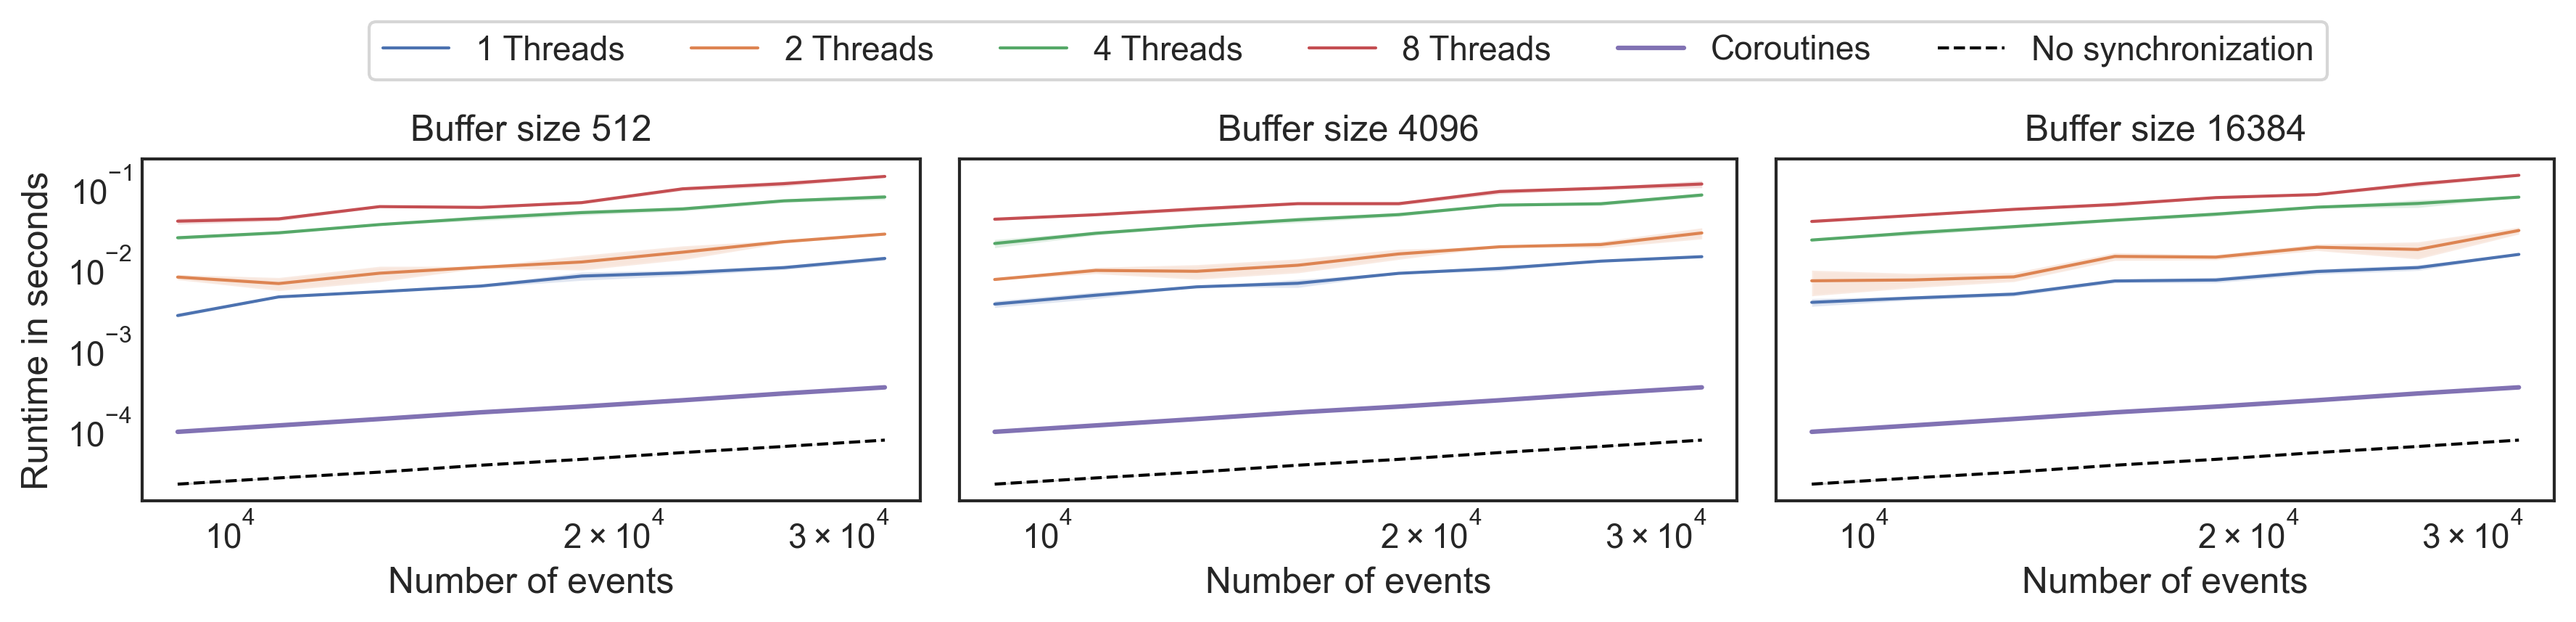

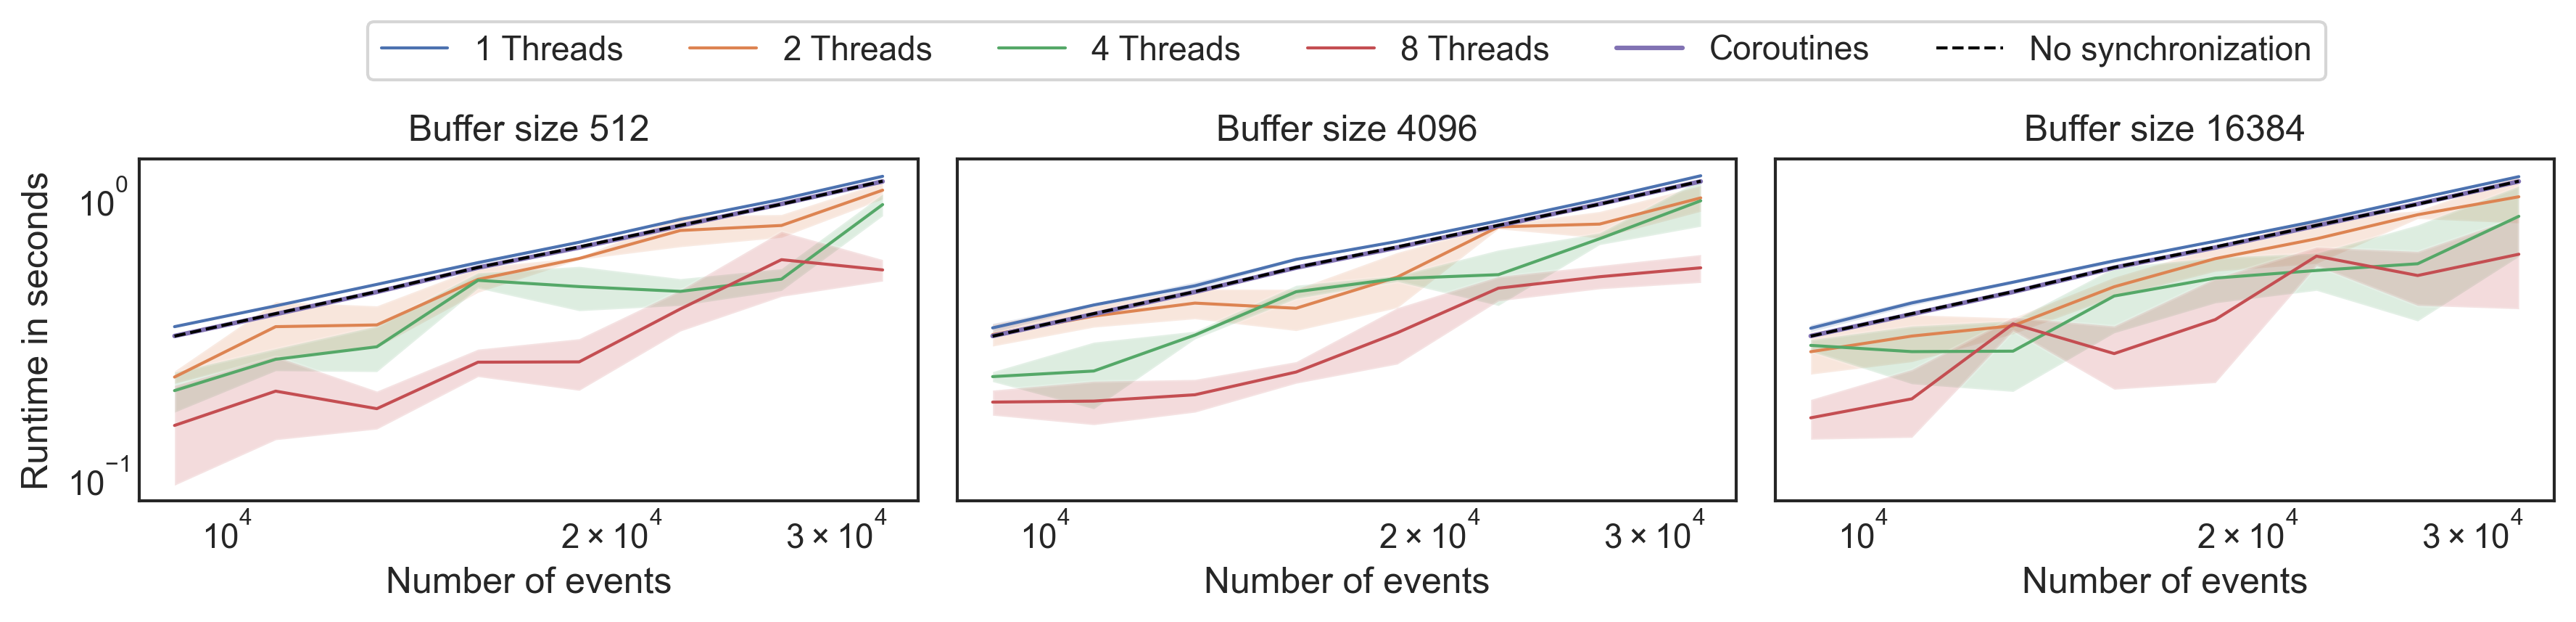

In [69]:
def plot_task(task):
    coroutines, threads, nothreads = fetch_data(task)
    std_up = lambda t: t[5] + t[6]
    std_down = lambda t: t[5] - t[6]
    
    buffer_sizes = df[df[0] != "c"][3].unique()
    n_threads = df[df[0] != "c"][2].unique()
    gs = matplotlib.gridspec.GridSpec(2, 3, height_ratios=[0.1, 0.9], hspace=0.2, wspace=0.04)
    f = plt.figure(figsize=(12, 3), dpi=300)
    #f, axes = plt.subplots(3, len(buffer_sizes) // 2, figsize=(12, 5), sharex=True, sharey=True, dpi=300)
    for i, b in enumerate([buffer_sizes[1], buffer_sizes[4], buffer_sizes[6]]):
        row = 0
        column = i % 3
        ax = f.add_subplot(gs[1 + row, column])
    
        # Threads
        ts = threads[threads[3] == b].groupby(2)
        for t_str, t in ts:
            t.plot(x=1, y=5, ax=ax, label=f"{t_str} Threads", logy=True, logx=True, linewidth=1)
            ax.fill_between(t[1], std_up(t), std_down(t), alpha=0.2)
            if row > 0:
                f.axes[i % 3].sharex(ax)
            if column > 0:
                ax.sharey(f.axes[row + (column -1 )])
    
        # Coroutines
        coroutines.plot(x=1, y=5, ax=ax, label="Coroutines")
        ax.fill_between(coroutines[1], std_up(coroutines), std_down(coroutines), alpha=0.2)
        
        # No threads
        nothreads.plot(x=1, y=5, ax=ax, label="No synchronization", c="black", linewidth=1, linestyle="dashed")
        ax.fill_between(nothreads[1], std_up(nothreads), std_down(nothreads), alpha=0.2, facecolor="black")
    
        ax.set_ylabel("Runtime in seconds")
        ax.set_xlabel("Number of events")
        ax.set_title(f"Buffer size {b}")
        #ax.set_ylim(1e-5, )
        ax.get_legend().remove()
    al = f.add_subplot(gs[0,:])
    al.axis("off")
    al.legend(ax.lines, [x.get_label() for x in ax.lines], loc="center", ncol=6, frameon=True, fancybox=True)
    # f.suptitle("Processing runtime for coroutines and buffered threads")
    gs.tight_layout(f)
    f.show()
    f.savefig(f"threads_{task}.png")

plot_task("simple")
plot_task("complex")

In [6]:
# std_up = lambda t: t[5] + t[6]
# std_down = lambda t: t[5] - t[6]


# buffer_sizes = df[df[0] != "c"][3].unique()
# n_threads = df[df[0] != "c"][2].unique()
# gs = matplotlib.gridspec.GridSpec(3, len(buffer_sizes) // 2, height_ratios=[0.1, 0.45, 0.45], hspace=0.2, wspace=0.04)
# f = plt.figure(figsize=(12, 4), dpi=300)
# #f, axes = plt.subplots(3, len(buffer_sizes) // 2, figsize=(12, 5), sharex=True, sharey=True, dpi=300)
# for i, b in enumerate([x for x in buffer_sizes if x > 0]):
#     row = i // (len(buffer_sizes) // 2)
#     column = i % 3
#     ax = f.add_subplot(gs[1 + row, column])

#     # Threads
#     ts = threads[threads[3] == b].groupby(2)
#     for t_str, t in ts:
#         t.plot(x=1, y=5, ax=ax, label=f"{t_str} Threads", logy=True, logx=True, linewidth=1)
#         ax.fill_between(t[1], std_up(t), std_down(t), alpha=0.2)
#         if row > 0:
#             f.axes[i % 3].sharex(ax)
#         if column > 0:
#             ax.sharey(f.axes[row + (column -1 )])

#     # Coroutines
#     coroutines.plot(x=1, y=5, ax=ax, label="Coroutines")
#     ax.fill_between(coroutines[1], std_up(coroutines), std_down(coroutines), alpha=0.2)
    
#     # No threads
#     nothreads.plot(x=1, y=5, ax=ax, label="No synchronization", c="black", linewidth=1, linestyle="dashed")
#     ax.fill_between(nothreads[1], std_up(nothreads), std_down(nothreads), alpha=0.2, facecolor="black")

#     ax.set_ylabel("Runtime in seconds")
#     ax.set_xlabel("Number of events")
#     ax.set_title(f"Buffer size {b}")
#     #ax.set_ylim(1e-5, )
#     ax.get_legend().remove()
# al = f.add_subplot(gs[0,:])
# al.axis("off")
# al.legend(ax.lines, [x.get_label() for x in ax.lines], loc="center", ncol=6, frameon=True, fancybox=True)
# # f.suptitle("Processing runtime for coroutines and buffered threads")
# gs.tight_layout(f)
# f.show()
# f.savefig("threads.png")

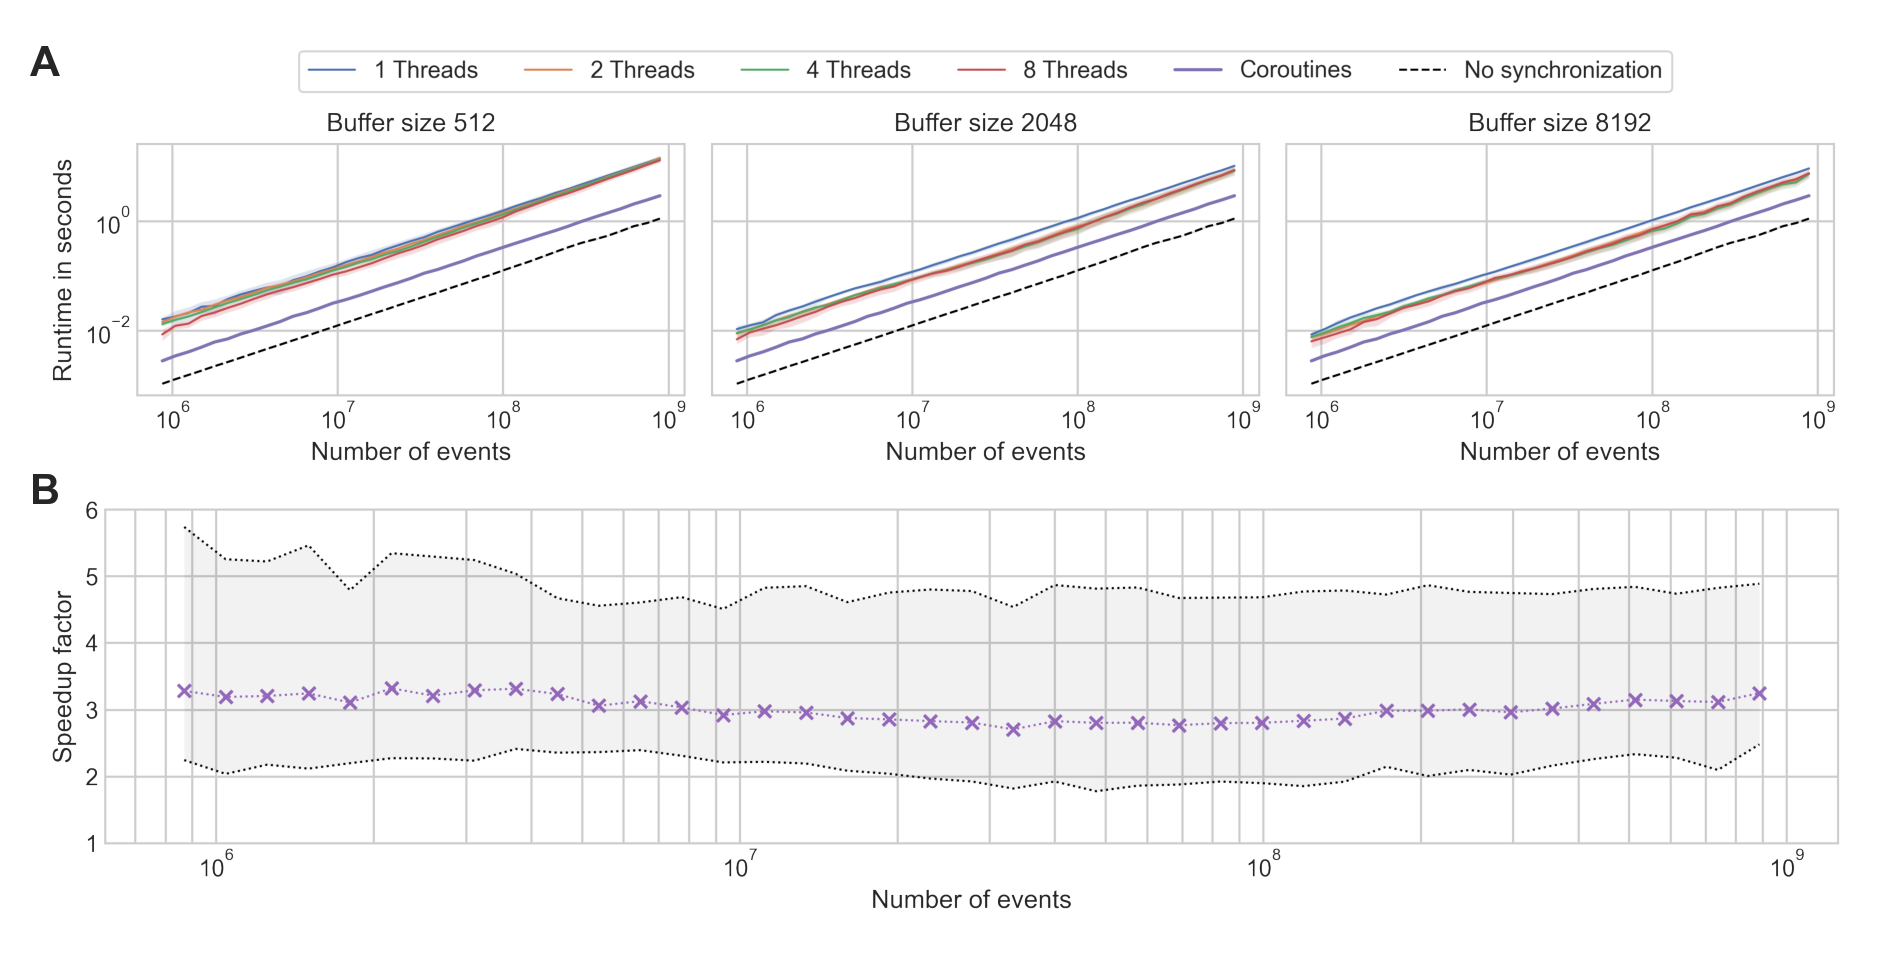

In [21]:
from PIL import Image
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=-0.02, wspace=0)
f = plt.figure(figsize=(12, 4), dpi=300)
a2 = f.add_subplot(gs[0])
a1 = f.add_subplot(gs[1])
a1.set_axis_off()
a2.set_axis_off()

im1 = Image.open("speedup.png")
a1.imshow(im1, aspect="equal")
im2 = Image.open("threads.png")
a2.imshow(im2, aspect="equal")

a2.text(0, 30, "A", horizontalalignment="left", verticalalignment="top", fontweight="bold")
a1.text(0, -10, "B", horizontalalignment="left", verticalalignment="top", fontweight="bold")

#gs.tight_layout(f, pad=0)
# f.tight_layout()
f.savefig("2212_speedup.png")
f.savefig("/media/ncs-tmp/Jens/2212_NICE/2212_aestream_speedup.png", bbox_inches="tight")

# GPU benchmark

In [18]:
df = pandas.read_csv("gpu_results.csv", header=None)
df.head() # ts, frames, totals

,0,1,2,3,4,5,6,7,8
0,cam0197.aedat4,405191.90625,10279.845703,55470.015625,1513.799561,2.718393e+10,4.013147e+07,cpu,True
1,cam0197.aedat4,404784.56250,9829.120117,50620.531250,1372.079102,2.479977e+10,3.126654e+05,cpu,False
2,cam0197.aedat4,369234.28125,3437.945312,65057.625000,598.343811,2.703262e+10,2.604515e+07,cuda,True
3,cam0197.aedat4,391970.43750,6688.226074,56324.187500,933.225647,2.479974e+10,3.334810e+05,cuda,False
4,cam0197.aedat4,398354.03125,6813.177246,56385.343750,1022.237366,2.716544e+10,3.277467e+07,cpu,True


In [19]:
nc = df[df[8] == False]
c = df[df[8] == True]

In [20]:
cpu_nc = nc[nc[7] == "cpu"]
cuda_nc = nc[nc[7] == "cuda"]
cpu_c = c[c[7] == "cpu"]
cuda_c = c[c[7] == "cuda"]

In [21]:
cpu_nc[3].mean(), cuda_nc[3].mean(), cpu_c[3].mean(), cuda_c[3].mean()

(50716.996875, 58104.828125, 55892.68125, 64879.74375)

In [22]:
memcpy = np.array(list({
    1: np.array([1838808376, 1810336691, 1778017724, 1848811785, 1787653681]).mean(),
    2: np.array([1992930259, 2018432996, 1995947453, 2007592777, 2021362894]).mean(),
    3: np.array([339539866, 339162751, 339561289, 340222764, 340583436]).mean(),
    4: np.array([340187602, 339485574, 338682298, 338781174, 340534461]).mean()
}.values()))
memcpy_pct = 100 * memcpy / [x[5].mean() for x in [cpu_nc, cpu_c, cuda_nc, cuda_c]] 
memcpy_s = np.array([175, 168, 48, 48]) / 1e9

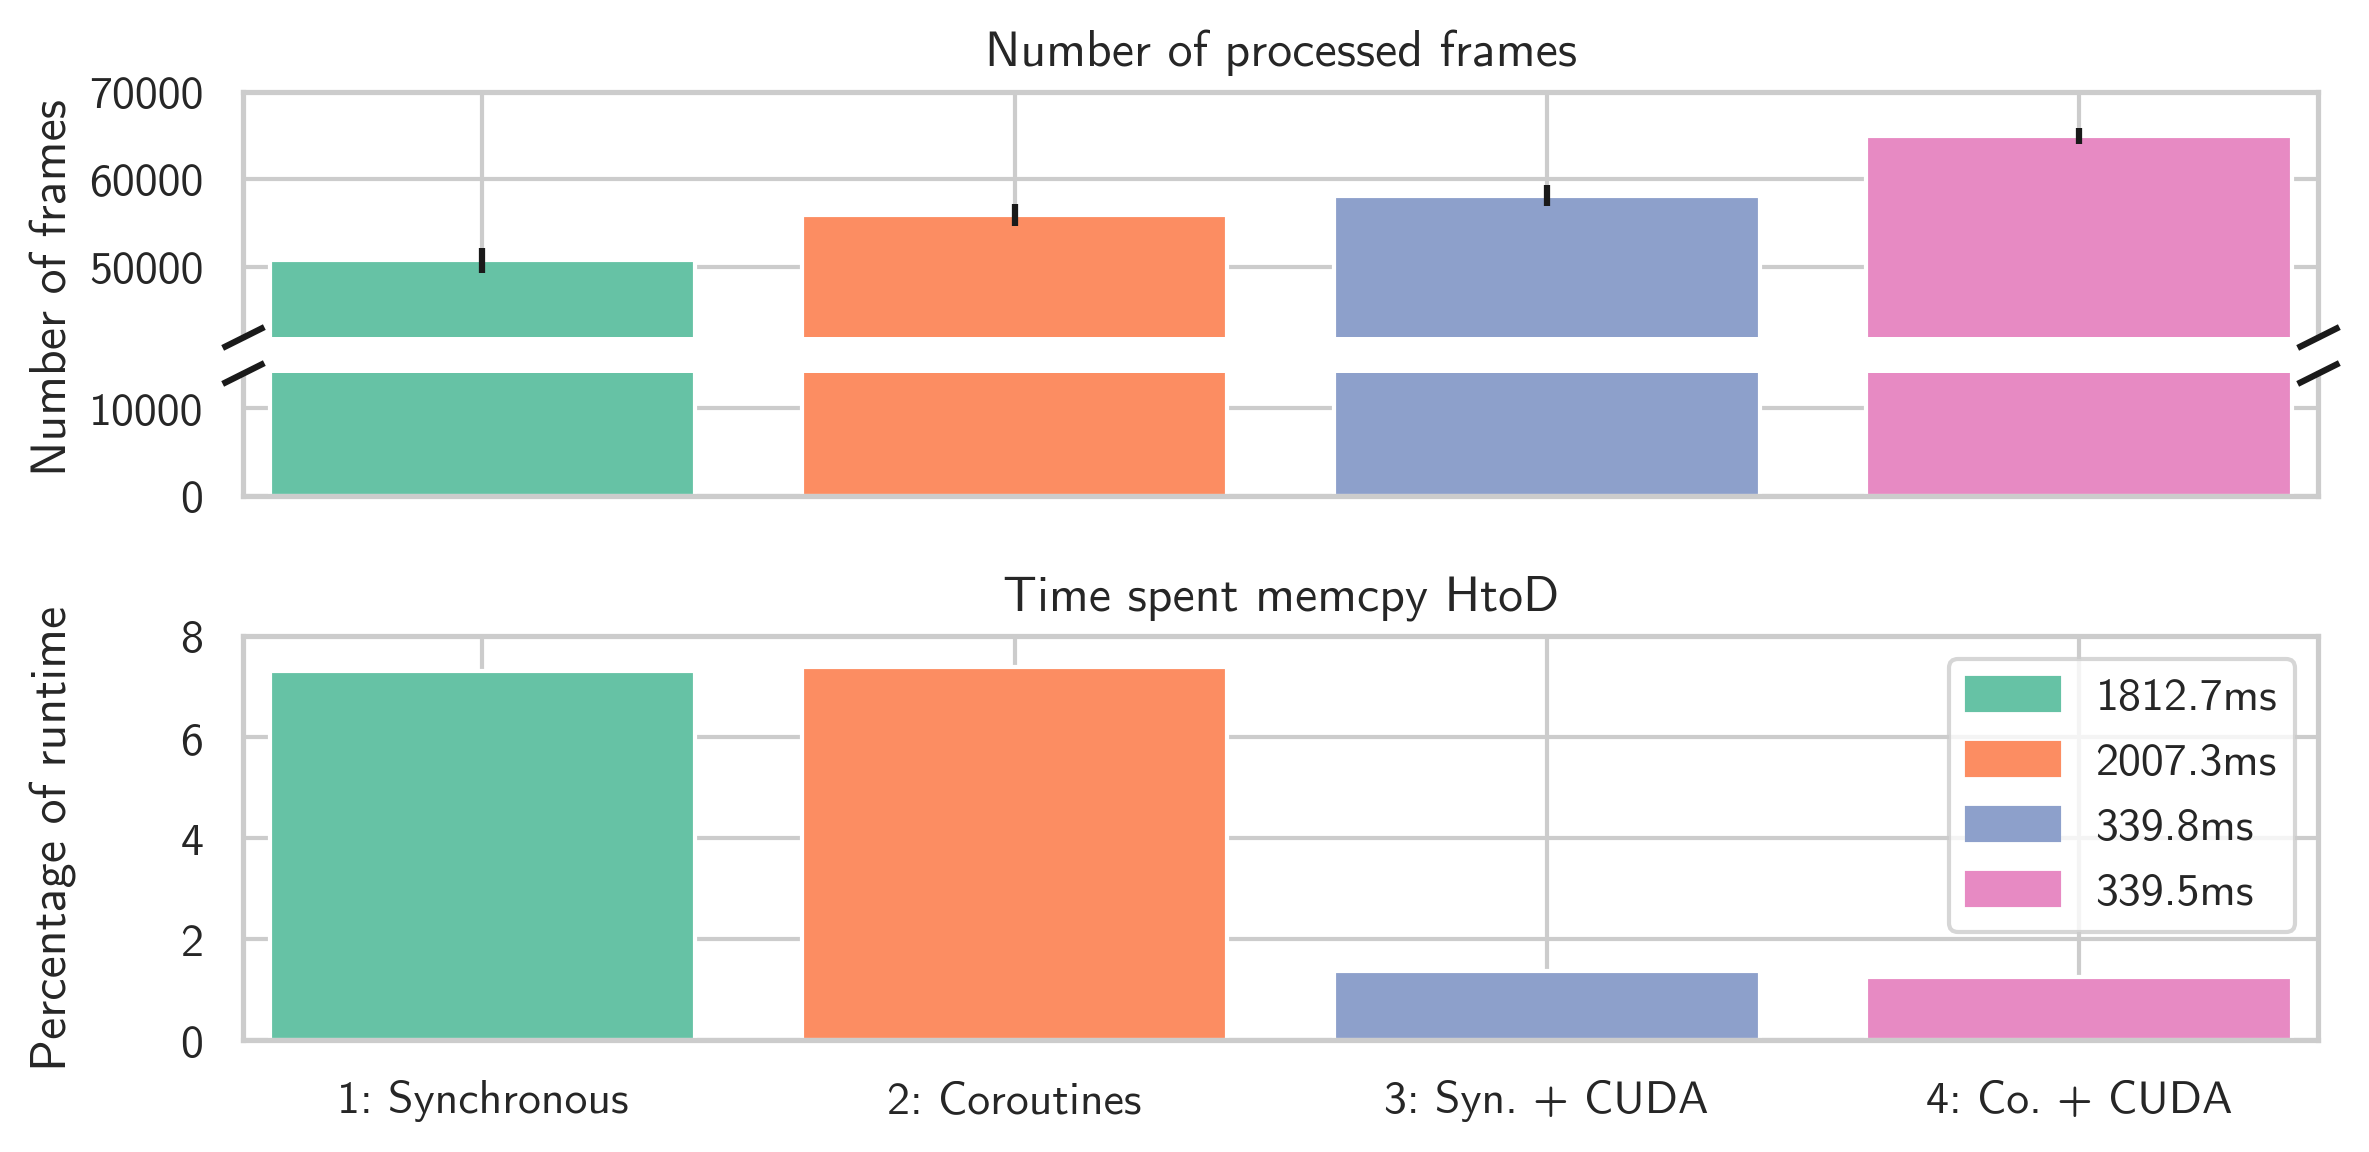

In [68]:
f = plt.figure(figsize=(8, 4), dpi=300)
gs = matplotlib.gridspec.GridSpec(2, 1)
#f, (a2, a1, a3) = plt.subplots(3, 1, figsize=(6, 4), dpi=100, constrained_layout=True, sharex=True, gridspec_kw={"height_ratios": [0.8, 0.5, 0.3]})
cmap = plt.get_cmap("Set2")
gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], height_ratios=[0.6, 0.3])
a1 = f.add_subplot(gs0[0])
a2 = f.add_subplot(gs[1], sharex=a1)
a3 = f.add_subplot(gs0[1], sharex=a1)
plt.setp(a3.get_xticklabels(), visible=False)

# Frames
a1.bar(
    [1, 2, 3, 4],
    [x[3].mean() for x in [cpu_nc, cpu_c, cuda_nc, cuda_c]],
    yerr = [x[4].mean() for x in [cpu_nc, cpu_c, cuda_nc, cuda_c]],
    color=[cmap(0), cmap(1), cmap(2), cmap(3)],
)
a1.set_title("Number of processed frames")
a1.set_xlim(0.55, 4.45)
a1.set_ylim(42000, 70000)
a1.set_ylabel("Number of frames")
a1.yaxis.set_label_coords(-0.08, 0.2)
# a1.set_xticks([1, 2, 3, 4], ["1: Synchronous", "2: Coroutines", "3: Syn. + CUDA", "4: Co. + CUDA"])
a1.spines.bottom.set_visible(False)
plt.setp(a1.get_xticklabels(), visible=False)

a3.set_ylim(0, 14000)
a3.bar(
    [1, 2, 3, 4],
    [x[3].mean() for x in [cpu_nc, cpu_c, cuda_nc, cuda_c]],
    yerr = [x[4].mean() for x in [cpu_nc, cpu_c, cuda_nc, cuda_c]],
    color=[cmap(0), cmap(1), cmap(2), cmap(3)],
)
a3.spines.top.set_visible(False)
#plt.setp(a3.get_xticklabels(), visible=False)

# Thanks: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
d= .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
              linestyle="none", color='k', mec='k', mew=1.5, clip_on=False, zorder=10)
a1.plot([0, 1], [0, 0], transform=a1.transAxes, **kwargs)
a3.plot([0, 1], [1, 1], transform=a3.transAxes, **kwargs)

# Memcpy
a2.bar(
    [1, 2, 3, 4],
    memcpy_pct,
    yerr=memcpy_s,
    color=[cmap(0), cmap(1), cmap(2), cmap(3)],
)
a2.set_title("Time spent memcpy HtoD")
a2.set_ylabel("Percentage of runtime")
a2.set_ylim(0, 8)
a2.yaxis.set_label_coords(-0.08, 0.5)
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(x)) for x in range(4)]
a2.legend(handles, [f"{x / 1e6:.1f}ms" for x in memcpy])
a2.set_xticks([1, 2, 3, 4], ["1: Synchronous", "2: Coroutines", "3: Syn. + CUDA", "4: Co. + CUDA"])
gs.tight_layout(f)
f.savefig("2212_gpu_frames.png", dpi=300, bbox_inches="tight")

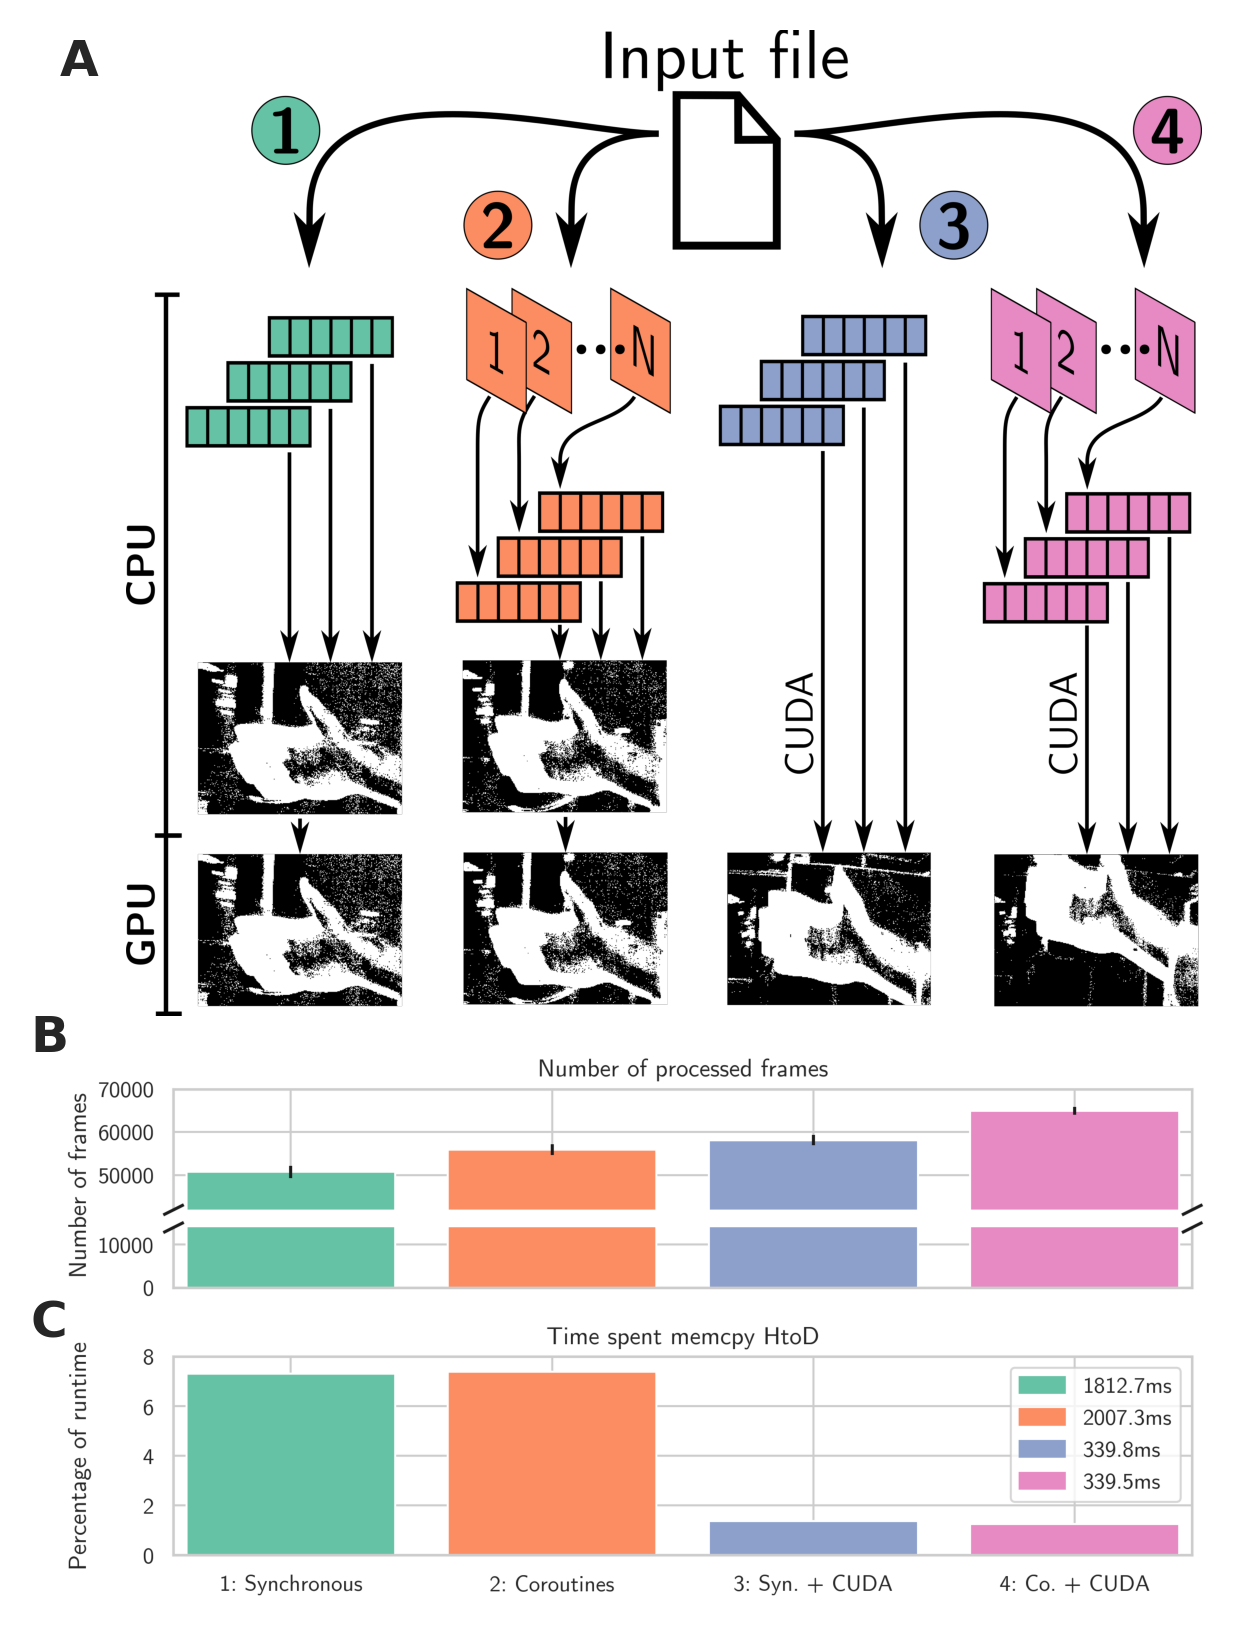

In [93]:
from PIL import Image
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[4, 2.59], hspace=-0.01, wspace=0)
f = plt.figure(figsize=(5, 7), dpi=300)
a1 = f.add_subplot(gs[0], anchor=(0.82, 0))
a2 = f.add_subplot(gs[1])
a1.set_axis_off()
a2.set_axis_off()

im1 = Image.open("/media/ncs-tmp/Jens/2212_NICE/2212_gpu_setup.png")
a1.imshow(im1, aspect=1)
im2 = Image.open("2212_gpu_frames.png")
a2.imshow(im2, aspect=1)

a1.text(-200, 30, r"$\bf{A}$", horizontalalignment="left", verticalalignment="top")
a2.text(-50, -60, r"$\bf{B}$", horizontalalignment="left", verticalalignment="top")
a2.text(-50, 520, r"$\bf{C}$", horizontalalignment="left", verticalalignment="top")

#gs.tight_layout(f, pad=0)
f.savefig("/media/ncs-tmp/Jens/2212_NICE/2212_aestream_gpu.png", bbox_inches="tight")

In [25]:
(1568892414727643 - 1568892389927647) / 1e6

24.799996